## Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import Tensor

# Lab 1 - California House

## Utils: split, scaler, bias

In [2]:
# ---------- Train/Test split (numpy) ----------
def train_test_split_np(X, y, test_size=0.2, random_state=42):
    rng = np.random.default_rng(random_state)
    n = X.shape[0]
    idx = np.arange(n)
    rng.shuffle(idx)
    n_test = int(round(n * test_size))
    test_idx = idx[:n_test]
    train_idx = idx[n_test:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


# ---------- Train/Val split (torch) ----------
def train_val_split_torch(X: Tensor, y: Tensor, val_size=0.1, random_state=42):
    """
    Split (X, y) into train and validation subsets (Torch version).
    """
    n = X.shape[0]
    g = torch.Generator().manual_seed(random_state)
    idx = torch.randperm(n, generator=g)
    n_val = int(round(n * val_size))
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]
    return X[train_idx], X[val_idx], y[train_idx], y[val_idx]


# ---------- Add bias column (torch) ----------
def add_bias_torch(X: Tensor) -> Tensor:
    """
    Add bias column of ones as the first column.
    """
    ones = torch.ones((X.shape[0], 1), device=X.device)
    return torch.cat([ones, X], dim=1)


# ---------- Standard Scaler for Torch ----------
class StandardScalerTorch:
    def __init__(self):
        self.mean_ = None  # Tensor, shape (n_features,)
        self.scale_ = None # Tensor, shape (n_features,)

    def fit(self, X: Tensor):
        # X: (n_samples, n_features)
        self.mean_ = X.mean(dim=0)
        self.scale_ = X.std(dim=0, unbiased=False) + 1e-12
        return self

    def transform(self, X: Tensor) -> Tensor:
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X: Tensor) -> Tensor:
        return self.fit(X).transform(X)

    def inverse_transform(self, X: Tensor) -> Tensor:
        return X * self.scale_ + self.mean_


# ---------- Numpy metrics  ----------
def compute_metrics_np(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Compute regression metrics in numpy on original scale.
    """
    mse = np.mean((y_pred - y_true) ** 2)
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(mse)

    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2) + 1e-15
    r2 = 1.0 - ss_res / ss_tot

    return mse, mae, rmse, r2


## Model LinearRegression

In [3]:
class LinearRegressionTorch:
    def __init__(self, l2: float = 0.0, device: str = None):
        """
        Simple linear regression with L2 regularization (Ridge),
        implemented from scratch using torch tensors (no nn.Module, no optim).
        """
        self.weights: Tensor = None
        self.l2 = l2
        self.train_mse = []
        self.val_mse = []
        self.train_r2 = []
        self.val_r2 = []

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device

    def compute_metrics(self, y_true: Tensor, y_pred: Tensor):
        """
        Compute MSE, MAE, RMSE, R2 in torch.
        y_true, y_pred: shape (n_samples,)
        """
        mse = torch.mean((y_pred - y_true) ** 2)
        mae = torch.mean(torch.abs(y_pred - y_true))
        rmse = torch.sqrt(mse)

        ss_res = torch.sum((y_true - y_pred) ** 2)
        ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2) + 1e-15
        r2 = 1.0 - ss_res / ss_tot

        return mse, mae, rmse, r2

    def fit(
        self,
        X: Tensor,
        y: Tensor,
        learning_rate: float = 0.01,
        epochs: int = 1000,
        validation_data=None,
        patience: int = 50,
        tol: float = 1e-6,
        verbose: bool = True,
    ):
        """
        Train with full-batch gradient descent and early stopping
        (no autograd, gradients computed by hand).
        """
        # Move data to device
        X = X.to(self.device)
        y = y.to(self.device)

        n_samples, n_features = X.shape
        # Initialize weights with zeros
        self.weights = torch.zeros(n_features, device=self.device)

        # Prepare validation set (if provided)
        Xv, yv = None, None
        if validation_data is not None:
            Xv, yv = validation_data
            Xv = Xv.to(self.device)
            yv = yv.to(self.device)

        best_val = float("inf")
        best_w = self.weights.clone()
        wait = 0

        for epoch in range(epochs):
            # ----- Forward -----
            y_pred = X @ self.weights  # shape (n_samples,)

            # ----- Train metrics -----
            mse, _, _, r2 = self.compute_metrics(y, y_pred)

            # L2 regularization (do not penalize bias term w[0])
            reg = self.l2 * torch.sum(self.weights[1:] ** 2)
            mse_reg = mse + reg

            self.train_mse.append(mse_reg.item())
            self.train_r2.append(r2.item())

            # ----- Validation -----
            if Xv is not None and yv is not None:
                yv_pred = Xv @ self.weights
                vmse, _, _, vr2 = self.compute_metrics(yv, yv_pred)
                vmse_reg = vmse + self.l2 * torch.sum(self.weights[1:] ** 2)

                self.val_mse.append(vmse_reg.item())
                self.val_r2.append(vr2.item())

                # Early stopping logic (on val MSE with regularization)
                if vmse_reg.item() + tol < best_val:
                    best_val = vmse_reg.item()
                    best_w = self.weights.clone()
                    wait = 0
                else:
                    wait += 1
                    if wait >= patience:
                        if verbose:
                            print(
                                f"[Early stop] epoch={epoch}, best val MSE={best_val:.6f}"
                            )
                        self.weights = best_w
                        break

            # ----- Gradient (manual, no autograd) -----
            # grad = (2/n) * X^T (y_pred - y)
            error = y_pred - y
            grad = (2.0 / n_samples) * (X.t() @ error)
            grad[1:] += 2.0 * self.l2 * self.weights[1:]  # L2 for non-bias terms

            # Update weights
            self.weights = self.weights - learning_rate * grad

            # Logging
            if verbose and epoch % 100 == 0:
                msg = f"Epoch {epoch:4d} | train MSE={mse.item():.6f}, R2={r2.item():.4f}"
                if Xv is not None and yv is not None:
                    msg += f" | val MSE={vmse.item():.6f}, val R2={vr2.item():.4f}"
                print(msg)

    def predict(self, X: Tensor) -> Tensor:
        """
        Predict using learned weights.
        Returns predictions on CPU (1D tensor).
        """
        X = X.to(self.device)
        with torch.no_grad():
            y_pred = X @ self.weights
        return y_pred.detach().cpu()


## Preprocessing dataset California

In [4]:
# === 1. Load data ===
csv_path = "/content/California_Houses.csv"

houses = pd.read_csv(csv_path)
print("Dataset shape:", houses.shape)
print(houses.head())
print("\nMissing values:")
print(houses.isnull().sum())

# y: first column (price), X: remaining features
y_np = houses.iloc[:, 0].values.astype(np.float32)
X_np = houses.iloc[:, 1:].values.astype(np.float32)

# === 2. Train/Test split (numpy) ===
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split_np(
    X_np, y_np, test_size=0.2, random_state=42
)

# === 3. Convert to torch tensors ===
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

X_train_t = torch.from_numpy(X_train_np).to(device)
X_test_t  = torch.from_numpy(X_test_np).to(device)
y_train_t = torch.from_numpy(y_train_np).to(device)
y_test_t  = torch.from_numpy(y_test_np).to(device)

# For y we will treat it as (N, 1) during scaling
y_train_t_2d = y_train_t.view(-1, 1)
y_test_t_2d  = y_test_t.view(-1, 1)

# === 4. Scaling with StandardScalerTorch ===
scaler_X = StandardScalerTorch()
scaler_y = StandardScalerTorch()

X_train_s = scaler_X.fit_transform(X_train_t)
X_test_s  = scaler_X.transform(X_test_t)

y_train_s_2d = scaler_y.fit_transform(y_train_t_2d)
y_test_s_2d  = scaler_y.transform(y_test_t_2d)

# For training, we want y as 1D tensor
y_train_s = y_train_s_2d.view(-1)
y_test_s  = y_test_s_2d.view(-1)

# === 5. Add bias term ===
X_train_b = add_bias_torch(X_train_s)
X_test_b  = add_bias_torch(X_test_s)

# === 6. Take validation from train (torch split) ===
X_tr, X_val, y_tr, y_val = train_val_split_torch(
    X_train_b, y_train_s, val_size=0.1, random_state=42
)


Dataset shape: (20640, 14)
   Median_House_Value  Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  \
0            452600.0         8.3252          41        880           129   
1            358500.0         8.3014          21       7099          1106   
2            352100.0         7.2574          52       1467           190   
3            341300.0         5.6431          52       1274           235   
4            342200.0         3.8462          52       1627           280   

   Population  Households  Latitude  Longitude  Distance_to_coast  \
0         322         126     37.88    -122.23        9263.040773   
1        2401        1138     37.86    -122.22       10225.733072   
2         496         177     37.85    -122.24        8259.085109   
3         558         219     37.85    -122.25        7768.086571   
4         565         259     37.85    -122.25        7768.086571   

   Distance_to_LA  Distance_to_SanDiego  Distance_to_SanJose  \
0   556529.158342         73550

## Train model LinearRegression & calculate metrics

In [6]:
# === 7. Train model ===
model_t = LinearRegressionTorch(l2=1e-3, device=device)

model_t.fit(
    X_tr, y_tr,
    learning_rate=0.01,
    epochs=5000,
    validation_data=(X_val, y_val),
    patience=200,
    tol=1e-7,
    verbose=True
)

# === 8. Predict (scaled) ===
y_pred_train_s = model_t.predict(X_train_b)  # 1D tensor on CPU
y_pred_test_s  = model_t.predict(X_test_b)

# Convert scaled predictions and true y back to original price scale
y_train_s_2d_cpu = y_train_s.detach().cpu().view(-1, 1)
y_test_s_2d_cpu  = y_test_s.detach().cpu().view(-1, 1)

y_pred_train_s_2d = y_pred_train_s.view(-1, 1)
y_pred_test_s_2d  = y_pred_test_s.view(-1, 1)

y_train_orig_t = scaler_y.inverse_transform(y_train_s_2d_cpu)
y_test_orig_t  = scaler_y.inverse_transform(y_test_s_2d_cpu)

y_pred_train_orig_t = scaler_y.inverse_transform(y_pred_train_s_2d)
y_pred_test_orig_t  = scaler_y.inverse_transform(y_pred_test_s_2d)

# Convert to numpy for metrics and plotting
y_train_orig = y_train_orig_t.view(-1).numpy()
y_test_orig  = y_test_orig_t.view(-1).numpy()
y_pred_train = y_pred_train_orig_t.view(-1).numpy()
y_pred_test  = y_pred_test_orig_t.view(-1).numpy()

# === 9. Metrics on original scale (numpy) ===
tr_mse, tr_mae, tr_rmse, tr_r2 = compute_metrics_np(y_train_orig, y_pred_train)
te_mse, te_mae, te_rmse, te_r2 = compute_metrics_np(y_test_orig,  y_pred_test)

print("\n=== Metrics on original scale (PyTorch model) ===")
print(f"[TRAIN] MSE={tr_mse:.3f} | MAE={tr_mae:.3f} | RMSE={tr_rmse:.3f} | R2={tr_r2:.4f}")
print(f"[TEST ] MSE={te_mse:.3f} | MAE={te_mae:.3f} | RMSE={te_rmse:.3f} | R2={te_r2:.4f}")


Epoch    0 | train MSE=1.000940, R2=-0.0000 | val MSE=0.991536, val R2=-0.0002
Epoch  100 | train MSE=0.391683, R2=0.6087 | val MSE=0.413204, val R2=0.5832
Epoch  200 | train MSE=0.375618, R2=0.6247 | val MSE=0.398457, val R2=0.5980
Epoch  300 | train MSE=0.368398, R2=0.6319 | val MSE=0.391693, val R2=0.6049
Epoch  400 | train MSE=0.363711, R2=0.6366 | val MSE=0.387692, val R2=0.6089
Epoch  500 | train MSE=0.360520, R2=0.6398 | val MSE=0.385264, val R2=0.6114
Epoch  600 | train MSE=0.358283, R2=0.6421 | val MSE=0.383756, val R2=0.6129
Epoch  700 | train MSE=0.356675, R2=0.6437 | val MSE=0.382792, val R2=0.6139
Epoch  800 | train MSE=0.355487, R2=0.6448 | val MSE=0.382150, val R2=0.6145
Epoch  900 | train MSE=0.354588, R2=0.6457 | val MSE=0.381699, val R2=0.6150
Epoch 1000 | train MSE=0.353891, R2=0.6464 | val MSE=0.381361, val R2=0.6153
Epoch 1100 | train MSE=0.353338, R2=0.6470 | val MSE=0.381091, val R2=0.6156
Epoch 1200 | train MSE=0.352890, R2=0.6474 | val MSE=0.380863, val R2=0.61

## Draw graphics

In [7]:
def recover_original_coeffs_torch(model_w: Tensor, scaler_X: StandardScalerTorch, scaler_y: StandardScalerTorch):
    """
    Recover coefficients on original scale from a model trained
    on standardized data with bias term included.
    """
    # Move everything to CPU numpy
    w = model_w.detach().cpu().numpy()
    w0 = w[0]        # bias in standardized space
    w_rest = w[1:]   # weights for standardized features

    sigma_y = scaler_y.scale_.detach().cpu().numpy()[0]
    mu_y    = scaler_y.mean_.detach().cpu().numpy()[0]

    sigma_X = scaler_X.scale_.detach().cpu().numpy()
    mu_X    = scaler_X.mean_.detach().cpu().numpy()

    beta = sigma_y * w_rest / sigma_X
    beta0 = mu_y + sigma_y * w0 - np.sum(beta * mu_X)

    return beta0, beta

beta0, beta = recover_original_coeffs_torch(model_t.weights, scaler_X, scaler_y)
feature_names = list(houses.columns[1:])
coef_table = pd.DataFrame({"feature": feature_names, "coef_original_scale": beta})
coef_table = coef_table.sort_values("coef_original_scale", key=lambda s: np.abs(s), ascending=False)

print("\n=== Features & Coefficients (original scale) ===")
print("Intercept (beta0):", beta0)
print(coef_table.to_string(index=False))



=== Features & Coefficients (original scale) ===
Intercept (beta0): -2510592.8
                 feature  coef_original_scale
           Median_Income         38864.621094
               Longitude        -26540.144531
                Latitude        -16937.318359
              Median_Age           975.617188
            Tot_Bedrooms            92.809692
              Households            69.045433
              Population           -46.340809
               Tot_Rooms            -4.491124
       Distance_to_coast            -0.352802
          Distance_to_LA            -0.121293
     Distance_to_SanJose             0.031777
Distance_to_SanFrancisco            -0.030485
    Distance_to_SanDiego             0.025643


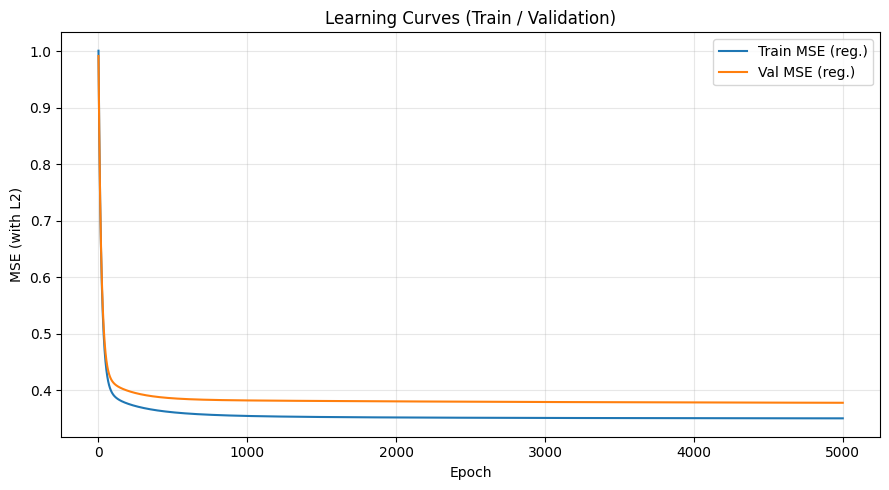

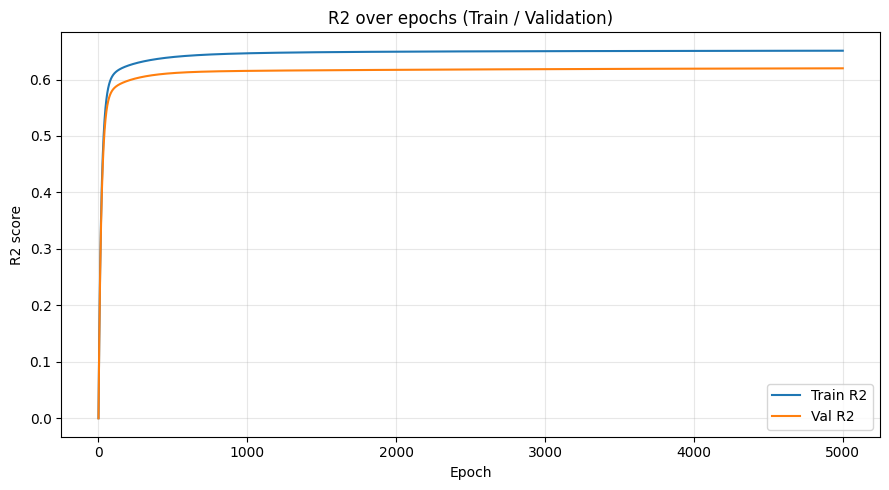

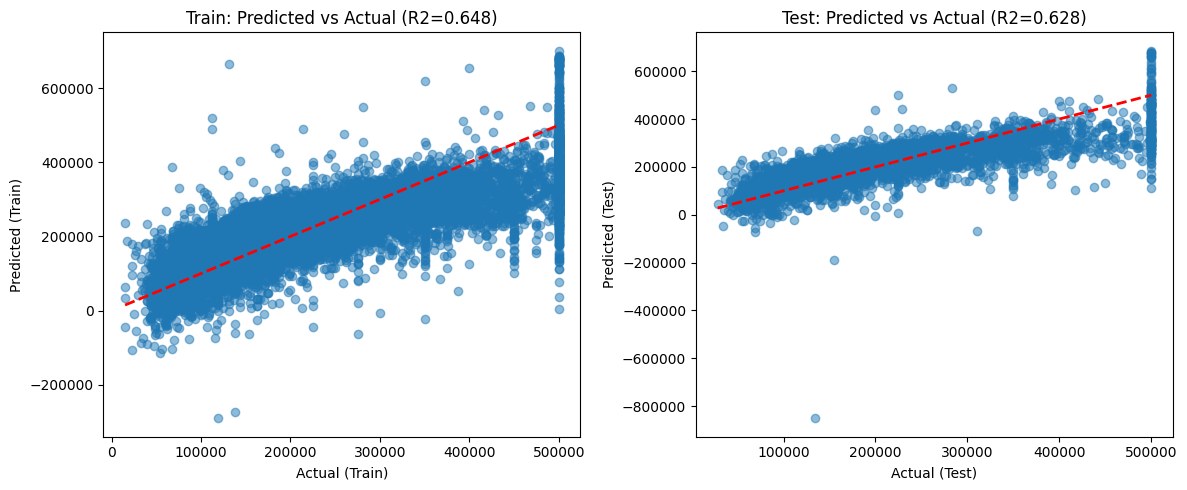

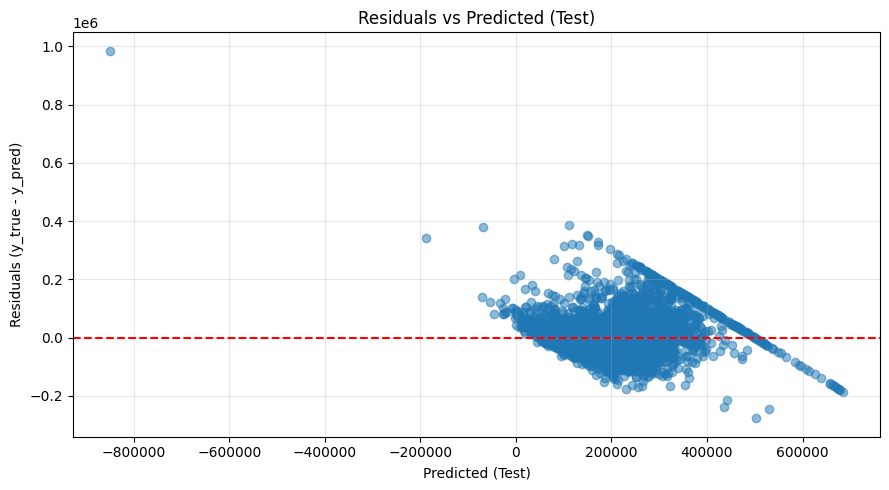

In [8]:
# 1) Learning curves (MSE)
epochs_seen = np.arange(1, len(model_t.train_mse) + 1)

plt.figure(figsize=(9, 5))
plt.plot(epochs_seen, model_t.train_mse, label="Train MSE (reg.)")
if len(model_t.val_mse) > 0:
    plt.plot(epochs_seen[:len(model_t.val_mse)], model_t.val_mse, label="Val MSE (reg.)")
plt.xlabel("Epoch")
plt.ylabel("MSE (with L2)")
plt.title("Learning Curves (Train / Validation)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) R2 over epochs (nếu muốn thêm)
plt.figure(figsize=(9, 5))
plt.plot(epochs_seen, model_t.train_r2, label="Train R2")
if len(model_t.val_r2) > 0:
    plt.plot(epochs_seen[:len(model_t.val_r2)], model_t.val_r2, label="Val R2")
plt.xlabel("Epoch")
plt.ylabel("R2 score")
plt.title("R2 over epochs (Train / Validation)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 3) Predicted vs Actual
plt.figure(figsize=(12, 5))

# Train
plt.subplot(1, 2, 1)
plt.scatter(y_train_orig, y_pred_train, alpha=0.5)
mn, mx = y_train_orig.min(), y_train_orig.max()
plt.plot([mn, mx], [mn, mx], 'r--', lw=2)
plt.xlabel("Actual (Train)")
plt.ylabel("Predicted (Train)")
plt.title(f"Train: Predicted vs Actual (R2={tr_r2:.3f})")

# Test
plt.subplot(1, 2, 2)
plt.scatter(y_test_orig, y_pred_test, alpha=0.5)
mn, mx = y_test_orig.min(), y_test_orig.max()
plt.plot([mn, mx], [mn, mx], 'r--', lw=2)
plt.xlabel("Actual (Test)")
plt.ylabel("Predicted (Test)")
plt.title(f"Test: Predicted vs Actual (R2={te_r2:.3f})")

plt.tight_layout()
plt.show()

# 4) Residual plot (Test)
residuals = y_test_orig - y_pred_test
plt.figure(figsize=(9, 5))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted (Test)")
plt.ylabel("Residuals (y_true - y_pred)")
plt.title("Residuals vs Predicted (Test)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Lab 1 - Titanic


## Utiles: split, scaler, metrics

In [12]:
def train_test_split_stratified(X, y, test_size=0.2, random_state=42):
    """
    Simple stratified train/test split (numpy version, no sklearn).
    """
    rng = np.random.default_rng(random_state)
    y = np.asarray(y)
    X = np.asarray(X)
    classes = np.unique(y)

    train_idx_list = []
    test_idx_list = []

    for c in classes:
        idx_c = np.where(y == c)[0]
        rng.shuffle(idx_c)
        n_test_c = int(round(len(idx_c) * test_size))
        test_idx_list.append(idx_c[:n_test_c])
        train_idx_list.append(idx_c[n_test_c:])

    train_idx = np.concatenate(train_idx_list)
    test_idx = np.concatenate(test_idx_list)

    rng.shuffle(train_idx)
    rng.shuffle(test_idx)

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


In [13]:
class StandardScalerNP:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X: np.ndarray):
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0, ddof=0) + 1e-12
        return self

    def transform(self, X: np.ndarray):
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X: np.ndarray):
        return self.fit(X).transform(X)


In [14]:
def accuracy_score_np(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(y_true == y_pred)


def precision_recall_f1_np(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp + 1e-15)
    recall    = tp / (tp + fn + 1e-15)
    f1        = 2 * precision * recall / (precision + recall + 1e-15)

    return precision, recall, f1


## Model LogisticRegressionTorch


In [15]:
class LogisticRegressionTorch:
    def __init__(self, device: str = None):
        """
        Binary logistic regression implemented from scratch using torch tensors.
        No nn.Module, no optim, no high-level loss functions.
        """
        self.W: Tensor = None
        self.b: Tensor = None

        self.loss_history = []
        self.accuracy_history = []
        self.f1_history = []
        self.metric_epochs = []

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device

    def _sigmoid(self, z: Tensor) -> Tensor:
        """
        Numerically stable sigmoid.
        """
        z_clamped = torch.clamp(z, -250.0, 250.0)
        return 1.0 / (1.0 + torch.exp(-z_clamped))

    def compute_loss(self, y_true: Tensor, y_pred_proba: Tensor) -> Tensor:
        """
        Binary cross-entropy loss:
        L = -1/N * sum[y*log(p) + (1-y)*log(1-p)]
        """
        eps = 1e-15
        p = torch.clamp(y_pred_proba, eps, 1.0 - eps)
        n = y_true.shape[0]
        loss = -torch.sum(y_true * torch.log(p) +
                          (1.0 - y_true) * torch.log(1.0 - p)) / n
        return loss

    def predict_proba(self, X: Tensor) -> Tensor:
        """
        Predict probabilities P(y=1|x).
        """
        X = X.to(self.device)
        with torch.no_grad():
            logits = X @ self.W + self.b
            proba = self._sigmoid(logits)
        return proba.detach().cpu()

    def predict(self, X: Tensor, threshold: float = 0.5) -> Tensor:
        """
        Predict class labels {0,1} from probabilities.
        """
        proba = self.predict_proba(X)
        return (proba > threshold).long()

    def fit(
        self,
        X: Tensor,
        y: Tensor,
        lr: float = 0.01,
        num_iter: int = 1000,
        validation_data=None,
        log_every: int = 100,
    ):
        """
        Full-batch gradient descent training.
        X: (n_samples, n_features)
        y: (n_samples,) with values {0,1}
        """
        # Move to device
        X = X.to(self.device)
        y = y.to(self.device)

        n_samples, n_features = X.shape

        # Initialize parameters
        self.W = torch.zeros(n_features, device=self.device)
        self.b = torch.tensor(0.0, device=self.device)

        # Validation data
        if validation_data is not None:
            X_val, y_val = validation_data
            X_val = X_val.to(self.device)
            y_val = y_val.to(self.device)
        else:
            X_val, y_val = X, y

        for epoch in range(num_iter):
            # ----- Forward pass -----
            logits = X @ self.W + self.b    # shape (n_samples,)
            y_pred_proba = self._sigmoid(logits)

            # ----- Loss -----
            loss = self.compute_loss(y, y_pred_proba)
            self.loss_history.append(loss.item())

            # ----- Gradients (manual, no autograd) -----
            # dL/dW = 1/N * X^T (p - y)
            # dL/db = 1/N * sum(p - y)
            error = (y_pred_proba - y)  # shape (n_samples,)
            dW = (X.t() @ error) / n_samples
            db = torch.sum(error) / n_samples

            # ----- Gradient step -----
            self.W = self.W - lr * dW
            self.b = self.b - lr * db

            # ----- Logging metrics on validation -----
            if epoch % log_every == 0:
                with torch.no_grad():
                    logits_val = X_val @ self.W + self.b
                    y_val_proba = self._sigmoid(logits_val)
                    y_val_pred = (y_val_proba > 0.5).long()

                # Convert to numpy for metrics
                y_val_np = y_val.detach().cpu().numpy()
                y_val_pred_np = y_val_pred.detach().cpu().numpy()

                acc = accuracy_score_np(y_val_np, y_val_pred_np)
                prec, rec, f1 = precision_recall_f1_np(y_val_np, y_val_pred_np)

                self.accuracy_history.append(acc)
                self.f1_history.append(f1)
                self.metric_epochs.append(epoch)

                print(
                    f"Epoch {epoch}: loss={loss.item():.4f}, "
                    f"acc={acc:.4f}, f1={f1:.4f}, prec={prec:.4f}, rec={rec:.4f}"
                )

## Preprocessing dataset Titanic

In [18]:
# === Load dataset (Titanic) ===
csv_path = "/content/Titanic-Dataset.csv"  # thay đường dẫn tương ứng trên Colab
titanic = pd.read_csv(csv_path)

print("Dataset shape:", titanic.shape)
print("\nFirst 5 rows:")
print(titanic.head())
print("\nMissing values:")
print(titanic.isnull().sum())

# === Preprocessing ===
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]
titanic = titanic.copy()

# Encode Sex: male→0, female→1
titanic["Sex"] = titanic["Sex"].map({"male": 0, "female": 1})

# Fill NA for selected features
for ft in features:
    if titanic[ft].isnull().sum() > 0:
        if titanic[ft].dtype == "object":
            titanic[ft] = titanic[ft].fillna(titanic[ft].mode()[0])
        else:
            titanic[ft] = titanic[ft].fillna(titanic[ft].median())

X_np = titanic[features].values.astype(np.float32)
y_np = titanic["Survived"].values.astype(np.int64)

# === Stratified train/test split (our own function) ===
x_train_raw, x_test_raw, y_train, y_test = train_test_split_stratified(
    X_np, y_np, test_size=0.2, random_state=42
)

# === Scaling (StandardScalerNP) ===
scaler = StandardScalerNP()
x_train = scaler.fit_transform(x_train_raw)
x_test  = scaler.transform(x_test_raw)

# === Convert to torch tensors ===
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

x_train_t = torch.from_numpy(x_train).to(device)
x_test_t  = torch.from_numpy(x_test).to(device)
y_train_t = torch.from_numpy(y_train.astype(np.float32)).to(device)  # for BCE
y_test_t  = torch.from_numpy(y_test.astype(np.float32)).to(device)


Dataset shape: (891, 12)

First 5 rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0       

## Train model LogisticRegressionTorch

In [19]:
# === Train model ===
model = LogisticRegressionTorch(device=device)

model.fit(
    x_train_t,
    y_train_t,
    lr=0.01,
    num_iter=1000,
    validation_data=(x_test_t, y_test_t),
    log_every=20,
)

# === Evaluate on test set ===
y_test_pred_t = model.predict(x_test_t)   # tensor {0,1} on CPU
y_test_pred_np = y_test_pred_t.numpy()
y_test_np = y_test.astype(np.int64)      # already numpy

acc_test = accuracy_score_np(y_test_np, y_test_pred_np)
prec_test, rec_test, f1_test = precision_recall_f1_np(y_test_np, y_test_pred_np)

print("\n=== REVIEW MODEL (Test) ===")
print(f"Accuracy:  {acc_test:.4f}")
print(f"F1 Score:  {f1_test:.4f}")
print(f"Precision: {prec_test:.4f}")
print(f"Recall:    {rec_test:.4f}")


Epoch 0: loss=0.6931, acc=0.7921, f1=0.7259, prec=0.7313, rec=0.7206
Epoch 20: loss=0.6699, acc=0.7921, f1=0.7259, prec=0.7313, rec=0.7206
Epoch 40: loss=0.6495, acc=0.7921, f1=0.7259, prec=0.7313, rec=0.7206
Epoch 60: loss=0.6317, acc=0.7921, f1=0.7259, prec=0.7313, rec=0.7206
Epoch 80: loss=0.6159, acc=0.7921, f1=0.7259, prec=0.7313, rec=0.7206
Epoch 100: loss=0.6020, acc=0.7921, f1=0.7259, prec=0.7313, rec=0.7206
Epoch 120: loss=0.5896, acc=0.7921, f1=0.7259, prec=0.7313, rec=0.7206
Epoch 140: loss=0.5786, acc=0.7921, f1=0.7259, prec=0.7313, rec=0.7206
Epoch 160: loss=0.5687, acc=0.7921, f1=0.7259, prec=0.7313, rec=0.7206
Epoch 180: loss=0.5599, acc=0.7921, f1=0.7259, prec=0.7313, rec=0.7206
Epoch 200: loss=0.5519, acc=0.7921, f1=0.7259, prec=0.7313, rec=0.7206
Epoch 220: loss=0.5447, acc=0.7921, f1=0.7259, prec=0.7313, rec=0.7206
Epoch 240: loss=0.5382, acc=0.7978, f1=0.7313, prec=0.7424, rec=0.7206
Epoch 260: loss=0.5323, acc=0.7978, f1=0.7313, prec=0.7424, rec=0.7206
Epoch 280: l

## Draw graphics

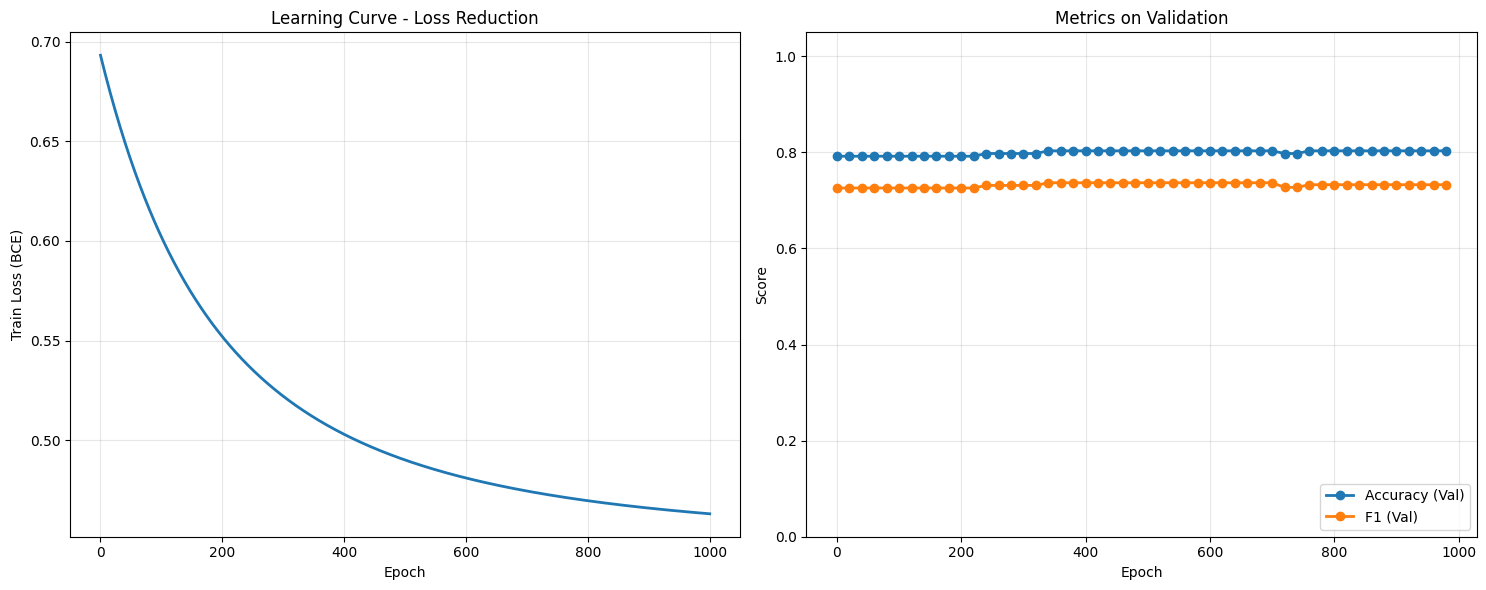

In [20]:
plt.figure(figsize=(15, 6))

# 1) Learning curve: loss
plt.subplot(1, 2, 1)
plt.plot(model.loss_history, '-', linewidth=2)
plt.title("Learning Curve - Loss Reduction")
plt.xlabel("Epoch")
plt.ylabel("Train Loss (BCE)")
plt.grid(True, alpha=0.3)

# 2) Metrics on validation
plt.subplot(1, 2, 2)
plt.plot(model.metric_epochs, model.accuracy_history, 'o-', linewidth=2, label="Accuracy (Val)")
plt.plot(model.metric_epochs, model.f1_history, 'o-', linewidth=2, label="F1 (Val)")
plt.title("Metrics on Validation")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()
